In [1]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np

# Evaluate Multi-Class


## Load file with predictions

In [2]:
prompt_ids_to_eval = ["P6", "P7", "P11_3", "P11_4"] #, "P2", "P3", "P4"
model = "gpt-4-turbo-preview"

In [3]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

In [4]:
df = pd.read_csv(f"predictions/{model}_enriched_kw_test_outputs_{'_'.join(prompt_ids_to_eval)}.csv")[columns_to_read]
#df = pd.read_csv(f"predictions/{model}_enriched_test_outputs_{'_'.join(prompt_ids_to_eval)}.csv")[columns_to_read]

In [5]:
df.shape

(534, 7)

In [6]:
df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P4_1,gpt_predictions_P5
0,12047012,Non-systematic-review,1,0,Remaining,Non-systematic-review,Non-systematic-review
1,28832188,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic-review
2,17678496,Non-systematic-review,1,0,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention
3,25649308,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic-review
4,6312596,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic-review


## Map predictions to numerical

In [7]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [8]:
numerical_to_label = {v: f"{v} - {k}" for k, v in label_to_numerical.items()}


In [9]:
import difflib

def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [10]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [11]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
df['accepted_label_numerical'] = df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


for col in prediction_columns:
    df[f'{col}_numerical'] = df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P4_1,gpt_predictions_P5,accepted_label_numerical,gpt_predictions_P1_numerical,gpt_predictions_P4_1_numerical,gpt_predictions_P5_numerical
0,12047012,Non-systematic-review,1,0,Remaining,Non-systematic-review,Non-systematic-review,1,0,1,1
1,28832188,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic-review,1,1,1,1
2,17678496,Non-systematic-review,1,0,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,1,2,2,2
3,25649308,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic-review,1,1,1,1
4,6312596,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic-review,1,1,1,1


#### Important: some labels from GPT could not be mapped to a target label

In [12]:
rows_with_minus_one = df[(df == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P4_1,gpt_predictions_P5,accepted_label_numerical,gpt_predictions_P1_numerical,gpt_predictions_P4_1_numerical,gpt_predictions_P5_numerical


## Evaluate prompts

In [13]:
def evaluate_predictions(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=range(len(label_to_numerical)), target_names=[numerical_to_label[i] for i in range(len(label_to_numerical))])

        
        # Create DataFrame from report
        report_df = pd.DataFrame(report).transpose()
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        summary = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{prompt_id}_{eval_type}.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_enriched_kw_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    summary_df.to_csv(f"evaluations/{model}_enriched_kw_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    #all_reports_df.to_csv(f"evaluations/{model}_enriched_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    #summary_df.to_csv(f"evaluations/{model}_enriched_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


Evaluating  P1
Evaluating  P4_1
Evaluating  P5
Results saved to evaluations/ and plots/ folders.


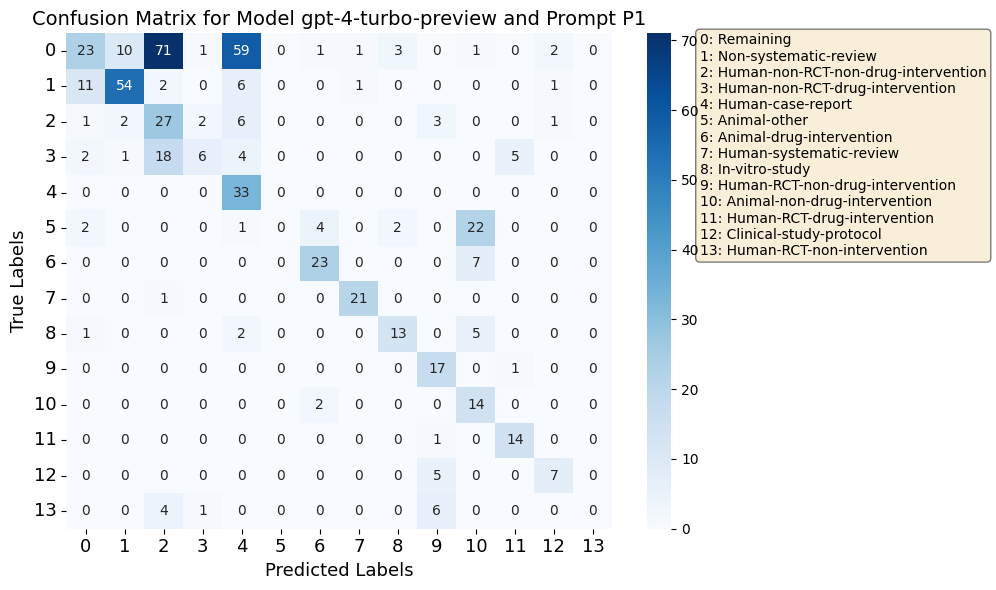

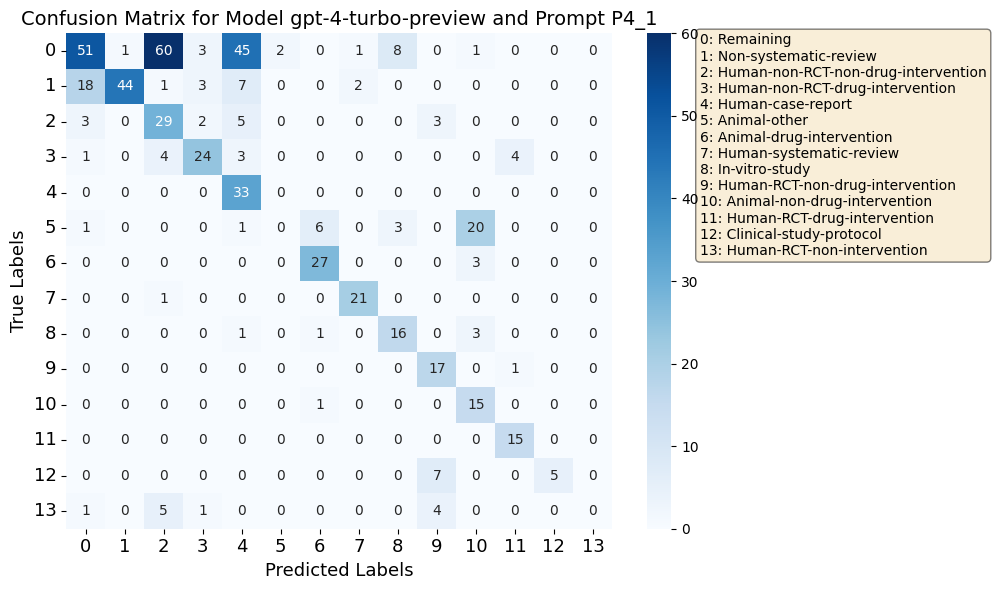

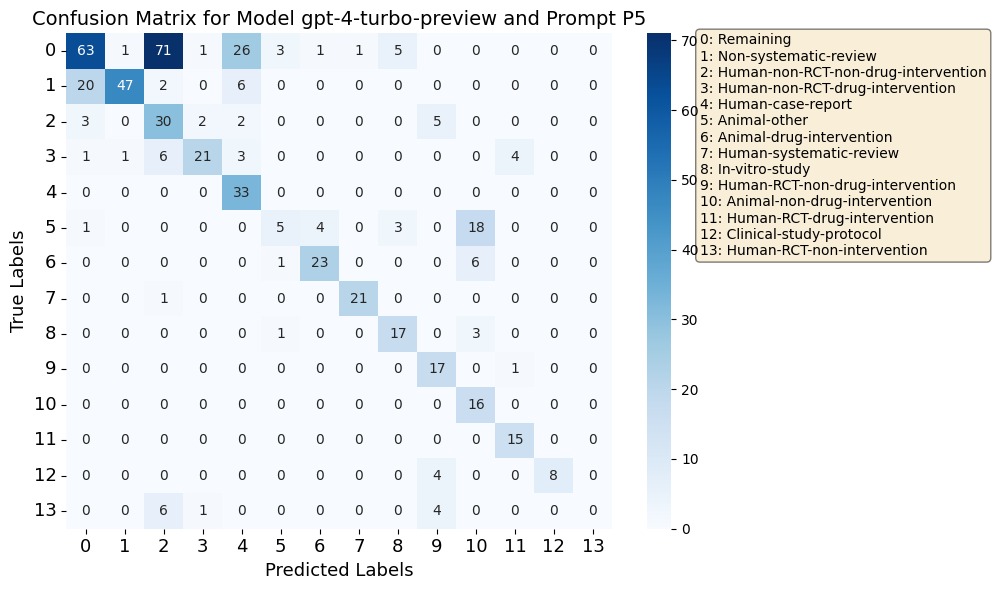

In [14]:
target_label_col = 'accepted_label_numerical'
eval_type = 'multi_label'
all_reports_df, summary_df = evaluate_predictions(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label)


In [15]:
summary_df

,precision,recall,f1-score,Prompt ID
0,0.544011,0.47191,0.428080,P1
1,0.625077,0.55618,0.533584,P4_1
2,0.686443,0.59176,0.587737,P5


In [16]:
all_reports_df

,precision,recall,f1-score,support,Prompt ID
0 - Remaining,0.575000,0.133721,0.216981,172.00000,P1
1 - Non-systematic-review,0.805970,0.720000,0.760563,75.00000,P1
2 - Human-non-RCT-non-drug-intervention,0.219512,0.642857,0.327273,42.00000,P1
3 - Human-non-RCT-drug-intervention,0.600000,0.166667,0.260870,36.00000,P1
4 - Human-case-report,0.297297,1.000000,0.458333,33.00000,P1
5 - Animal-other,0.000000,0.000000,0.000000,31.00000,P1
6 - Animal-drug-intervention,0.766667,0.766667,0.766667,30.00000,P1
7 - Human-systematic-review,0.913043,0.954545,0.933333,22.00000,P1
8 - In-vitro-study,0.722222,0.619048,0.666667,21.00000,P1
9 - Human-RCT-non-drug-intervention,0.531250,0.944444,0.680000,18.00000,P1
